In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import pandas as pd
import tensorflow as tf
import mdn

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


In [3]:
def get_ids(location):
    ids = os.listdir()
    id_nums = [int(id_.split('-')[0]) for id_ in ids if id_[-3:] == 'npy']
    return id_nums

id_nums = get_ids('.')
id_nums

[0, 5, 7, 9]

In [4]:
def get_trajectory_img_pair(id_num):
    
    trajectory = np.load(f'{id_num}-trajectory.npy')
    img_ids = [group for group in os.listdir('./RGB') if int(group.split('-')[-1].split('.')[0]) == int(id_num)]
    img_df = pd.DataFrame({'img_id':img_ids})
    trajectory_img_ids = [('%08d' % trajectory_id + f'-{id_num}.png') for trajectory_id in trajectory[:, 0]]
    trajectory_df = pd.DataFrame({'img_id':trajectory_img_ids, 'x': trajectory[:, 1], 'y': trajectory[:, 2]})
    
    return pd.merge(trajectory_df, img_df, on='img_id')

In [33]:
df = get_trajectory_img_pair(id_nums[-1])
df 

,img_id,x,y
0,00056481-9.png,-149.063416,-44.681843
1,00056484-9.png,-149.060028,-44.366650
2,00056487-9.png,-149.055023,-43.902119
3,00056490-9.png,-149.049881,-43.430801
4,00056493-9.png,-149.043213,-42.825333
5,00056496-9.png,-149.037842,-42.342911
6,00056499-9.png,-149.032455,-41.862015
7,00056502-9.png,-149.028183,-41.486526
8,00056505-9.png,-149.020264,-40.792500
9,00056508-9.png,-149.017929,-40.589115


In [34]:
def rotate(x, y, rad):
    x_rot = np.cos(rad)*x - np.sin(rad)*y
    y_rot = np.sin(rad)*x + np.cos(rad)*y
    return -x_rot, y_rot

def to_car_reference(df):
    transformed = df[['x', 'y']].values - df[['x', 'y']].values[0]
    angle =  np.arctan2(transformed[5][0], transformed[5][1]) 
    X, Y = rotate(transformed[:, 0], transformed[:, 1], (angle))
    return X, Y, df['img_id'].values

X, Y, img_paths = to_car_reference(df[300:])

In [35]:
plt.plot(X, Y)
plt.show()

<IPython.core.display.Javascript object>


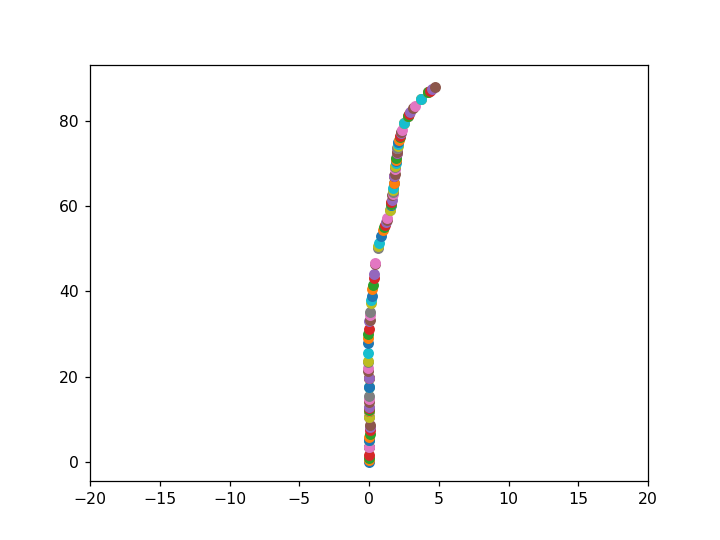

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.set_xlim([-20,20])

fig.show()
fig.canvas.draw()


for img_path, x, y  in zip(img_paths, X, Y):
    img = cv2.imread('./RGB/' + str(img_path))
    cv2.imshow('img', img)
    try:
        ax.scatter(x, y)
        fig.canvas.draw()
    except:
        pass
    
    k = cv2.waitKey(ord('q'))
    if k == -1: 
        continue
    else:
        break
        
cv2.destroyWindow('img') 

In [31]:
def return_polyfit_line(points):

    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    return x, y

In [36]:
from scipy.interpolate import CubicSpline

def return_polyfit_line(points):

    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    y_new = []
    x_new = []
    for i in range(1, len(y)):
        if y[i-1] < y[i]:
            y_new.append(y[i])
            x_new.append(x[i])
    y_needed = np.arange(0, 50, 1) 
    cs = CubicSpline(y_new, x_new)
    return cs(y_needed), y_needed

In [43]:
'''fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()'''

MAX_FRAMES = 150

for id_num in id_nums:
    dataset = []
    img_tags = []
    df = get_trajectory_img_pair(id_num)
    done = False
    for start in range(len(df)):
        X, Y, img_paths = to_car_reference(df[start:])
        img_tag = img_paths[0]
        counter = 0
        checkpoint = 0
        points = []
        flag = True
        while checkpoint <= 50:
            try:
                x, y = X[counter], Y[counter]
            except IndexError:
                done = True
                break
            checkpoint = int(y) 
            points.append([x, y])

            if counter > MAX_FRAMES:
                flag = False
                break

            counter += 1
        if done:
            break
        if flag:
            a, b = return_polyfit_line(points)
            #ax.plot(a, b)
            #fig.canvas.draw()
            dataset.append(a)
            img_tags.append(img_tag)

            if start % 50  == 0:
                print('50 sequences added')

            if start % 300  == 0:
                np.save(f'./Dataset/trajectories-{id_num}', np.array(dataset))
                np.save(f'./Dataset/img_tags-{id_num}', np.array(img_tags))
                print('Checkpoint reached')
        else:
            #print('skipped', counter)
            pass
    print(f'ID: {id_num} done' )

50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
ID: 5 done
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
ID: 7 done
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
50 sequences added
50 sequences added
Checkpoint reached
50 sequences added
50 sequences added
50 sequences added
ID: 9 don

# Reload Data 

In [5]:
all_tags = []
all_trajectories = []


def get_dataset_by_id(id_num):
    return np.load(f'./Dataset/img_tags-{id_num}.npy'), np.load(f'./Dataset/trajectories-{id_num}.npy')

for i in id_nums[1:]:
    img_tags_test, trajectory_test = get_dataset_by_id(i)
    all_tags.append(img_tags_test)
    all_trajectories.append(trajectory_test)
    
all_tags = np.concatenate(all_tags)
all_trajectories = np.concatenate(all_trajectories)

C:\Users\asus\Anaconda3\envs\envName\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


KeyboardInterrupt: 

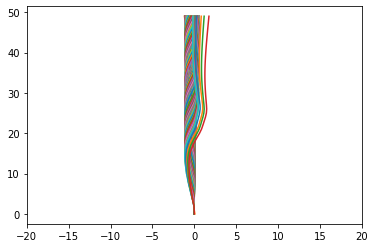

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.set_xlim([-20,20])

fig.show()
fig.canvas.draw()

for img_path, traj in zip(img_tags_test, trajectory_test):
    
    #img = cv2.imread('C:\Users\asus\Desktop\Self Driving\Comma Scratch\datacenter/' + str(img_path))
    #cv2.imshow('img', img)
    plt.plot(traj, range(0, 50))
    fig.canvas.draw()
    
    '''k = cv2.waitKey(ord('q'))
    if k == -1: 
        continue
    else:
        break'''
        
cv2.destroyWindow('img') 

In [6]:
import keras.backend as K
from keras import Input, Model
from keras import Sequential
from keras.layers import Convolution2D, ReLU, LeakyReLU, BatchNormalization, Conv2D, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam

In [7]:
from skimage.util import random_noise
from itertools import product, permutations
import random

def add_noise(image):
    return (random_noise(image/255)*255).astype('int')

def color_change(image):
    indices = list(permutations(range(3), 3))  
    idx = np.random.randint(0, len(indices) - 1)
    return image[..., indices[idx]]

def flip(image):                                                       
    image = np.flip(image, 1)
    return image

def augment(image, functions=[color_change]):
    function = np.random.choice(functions)
    aug_img = function(image)

    return aug_img.astype('int')

In [8]:
from tensorflow.keras.utils import Sequence

class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, img_paths, trajectories, base_path, to_fit=True, batch_size=16, shuffle=True, augmentation_rate=0.5):
    
        self.img_paths = img_paths
        self.trajectories = trajectories
        self.augmentation_rate = augmentation_rate
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = []
        y = self.trajectories[current_indexes]
        
        for idx, path in enumerate(img_paths_temp):
            img = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, path)), cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img.shape[1]//2 ,img.shape[0]//2))
            if (np.random.random() < self.augmentation_rate):
                img = augment(img)

            if (np.random.random() < 0.5) and self.augmentation_rate:
                img = flip(img)
                y[idx] = -y[idx]
                    
            img = img / 255.0
            X.append(img)

        if self.to_fit:
            return np.array(X), y 
        return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.trajectories = self.trajectories[indices]

In [9]:
val_cut = 100

train_generator = DataGenerator2D(all_tags[val_cut:], all_trajectories[val_cut:], './RGB', batch_size=16, shuffle=True, augmentation_rate=0.4)
val_generator = DataGenerator2D(all_tags[:val_cut], all_trajectories[:val_cut], './RGB', batch_size=1)

In [48]:
# Test the generator

X, y = train_generator.__getitem__(50)
print(X.shape, y.shape)

(16, 240, 320, 3) (16, 50)


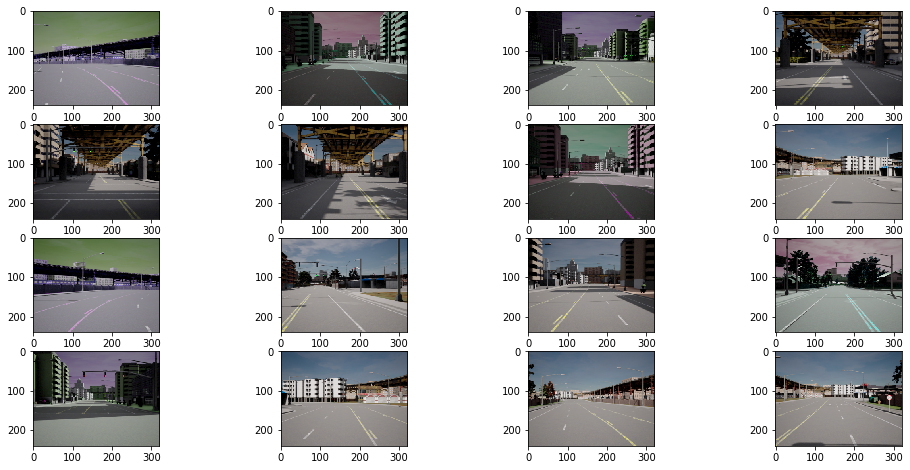

In [11]:
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

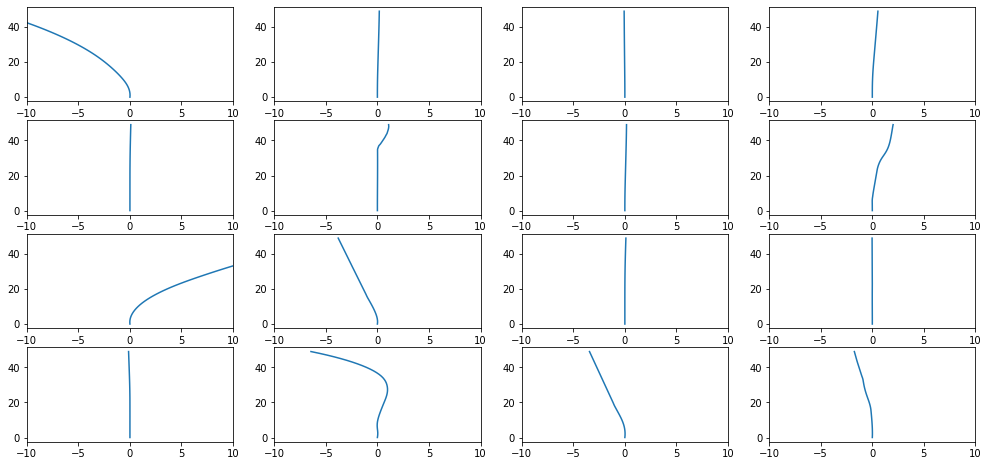

In [12]:
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    traj = y[i-1]
    ax = fig.add_subplot(rows, columns, i)
    plt.plot(traj, range(0, 50))
    ax.set_xlim([-10, 10])
plt.show()

In [34]:
from keras.layers import LeakyReLU, ReLU, BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(include_top=False, input_shape=(240, 320, 3))
# Select Number of layers to freeze

for layer in base_model.layers[:5]:
    layer.trainable = False

In [376]:
def build_finetune_model(base_model):

    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = ReLU()(x)
    x = Dropout(.5)(x)
    x = Dense(128)(x)
    x = ReLU()(x)
    predictions = Dense(50)(x)

    # this is the model we will train
    model = Model(input=base_model.input, output=predictions)

    return model

model = build_finetune_model(base_model)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [114]:
N_MIXES = 1

def get_model(N_MIXES):
    model = Sequential()
  
    model.add(Conv2D(16, (5, 5), strides=2, padding='same', input_shape=(240, 320, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(32, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

              
    model.add(Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    #model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(ReLU())
    model.add(mdn.MDN(50, N_MIXES))
    #model.add(Dense(50))
      
    return model

In [115]:
model = get_model(N_MIXES)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 120, 160, 16)      1216      
_________________________________________________________________
batch_normalization_33 (Batc (None, 120, 160, 16)      64        
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 80, 32)        12832     
_________________________________________________________________
batch_normalization_34 (Batc (None, 60, 80, 32)        128       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 30, 40, 64)       

In [116]:
def spline_loss(y_true, y_pred):
    dx_true = y_true[:, 1:] - y_true[:, :-1]
    dx_pred = y_pred[:, 1:] - y_pred[:, :-1]

    gradient_loss = K.mean(K.abs(dx_true - dx_pred), axis=-1)
    mae = K.mean(K.abs(y_true - y_pred), axis=-1)
    
    return mae + gradient_loss 

In [117]:
def mdn_spline_loss(y_true, y_pred):
    loss1 = mdn.get_mixture_loss_func(50, N_MIXES)(y_true, y_pred)
    loss2 = spline_loss(y_true, y_pred[:, :50])
    
    return loss1 + loss2

In [118]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(1e-3), loss=mdn_spline_loss)

In [119]:
NUM_EPOCHS = 20

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                      shuffle=True, validation_data= val_generator)

Epoch 1/20
77/77 [==============================] - 20s 256ms/step - loss: 553.3235 - val_loss: 55.7337
Epoch 2/20
77/77 [==============================] - 19s 244ms/step - loss: 104.4007 - val_loss: 85.4370
Epoch 3/20
77/77 [==============================] - 19s 246ms/step - loss: 92.8602 - val_loss: 49.7983
Epoch 4/20
77/77 [==============================] - 18s 233ms/step - loss: 82.7667 - val_loss: 949.1368
Epoch 5/20
77/77 [==============================] - 17s 218ms/step - loss: 67.7669 - val_loss: 116.7563
Epoch 6/20
77/77 [==============================] - 15s 196ms/step - loss: 52.1845 - val_loss: 661.8363
Epoch 7/20
77/77 [==============================] - 15s 196ms/step - loss: 41.8617 - val_loss: 380.5723
Epoch 8/20
77/77 [==============================] - 17s 221ms/step - loss: 35.9562 - val_loss: 68.1183
Epoch 9/20
77/77 [==============================] - 16s 205ms/step - loss: 27.1761 - val_loss: 60.3455
Epoch 10/20
77/77 [==============================] - 17s 215ms/step

KeyboardInterrupt: 

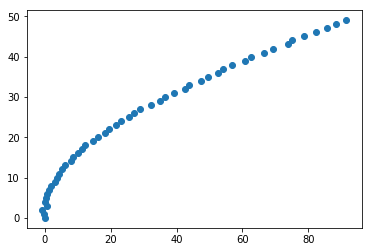

In [431]:
pred = model.predict(np.array([X[10]]))
plt.scatter(pred[0], range(0, 50))

In [42]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/device:GPU:0']

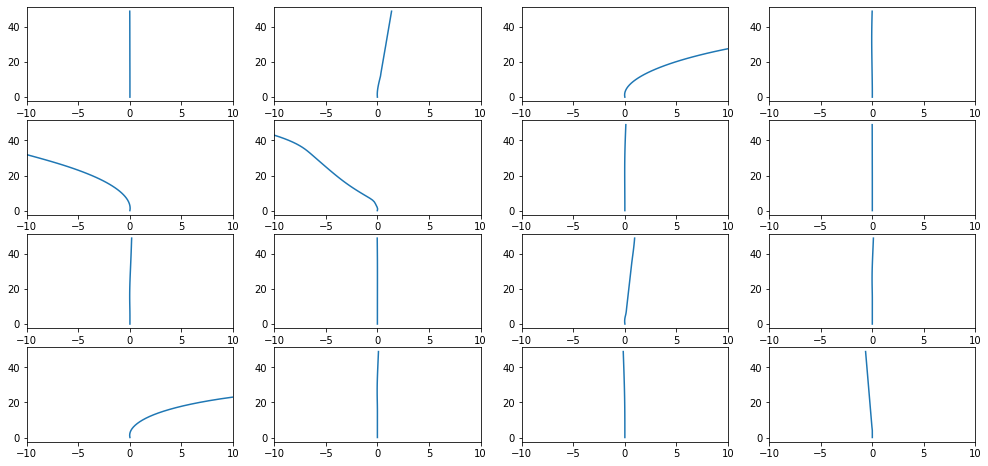

In [50]:
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    traj = y[i-1]
    ax = fig.add_subplot(rows, columns, i)
    plt.plot(traj, range(0, 50))
    ax.set_xlim([-10, 10])
plt.show()

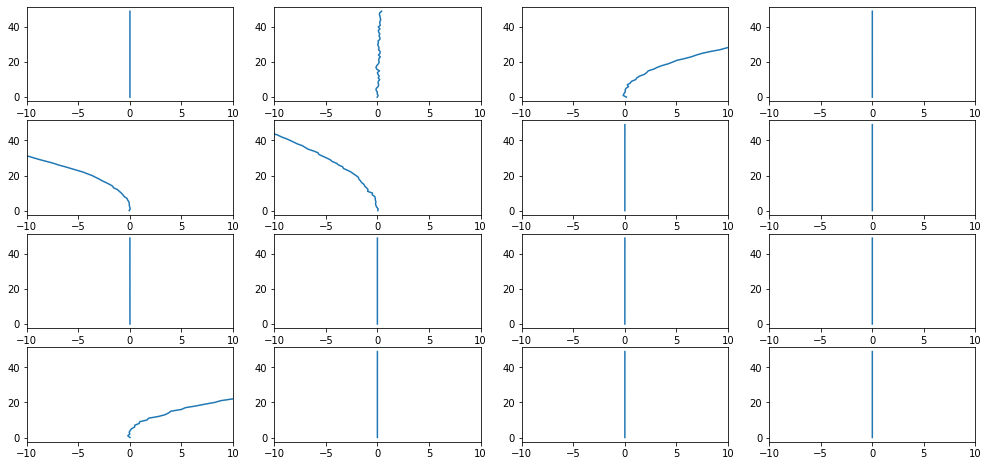

In [49]:
pred = model.predict(X)
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    traj = pred[i-1]
    ax = fig.add_subplot(rows, columns, i)
    plt.plot(traj, range(0, 50))
    ax.set_xlim([-10, 10])
plt.show()

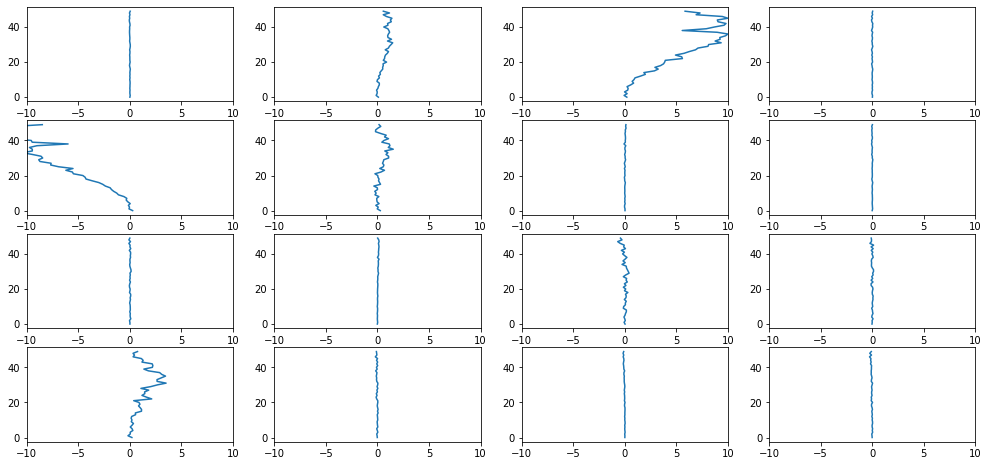

In [125]:
pred = model.predict(X)
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    traj = pred[i-1][0:50]
    ax = fig.add_subplot(rows, columns, i)
    plt.plot(traj, range(0, 50))
    ax.set_xlim([-10, 10])
plt.show()

In [95]:
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, pred, 50, N_MIXES, temp=1.0, sigma_temp=0)

In [96]:
y_samples.shape

(16, 1, 50)

ValueError: x and y must have same first dimension, but have shapes (101,) and (50,)

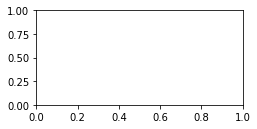

In [124]:
pred = model.predict(X)
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    traj = y_samples[i-1][0]
    ax = fig.add_subplot(rows, columns, i)
    plt.plot(traj, range(0, 50))
    ax.set_xlim([-10, 10])
plt.show()

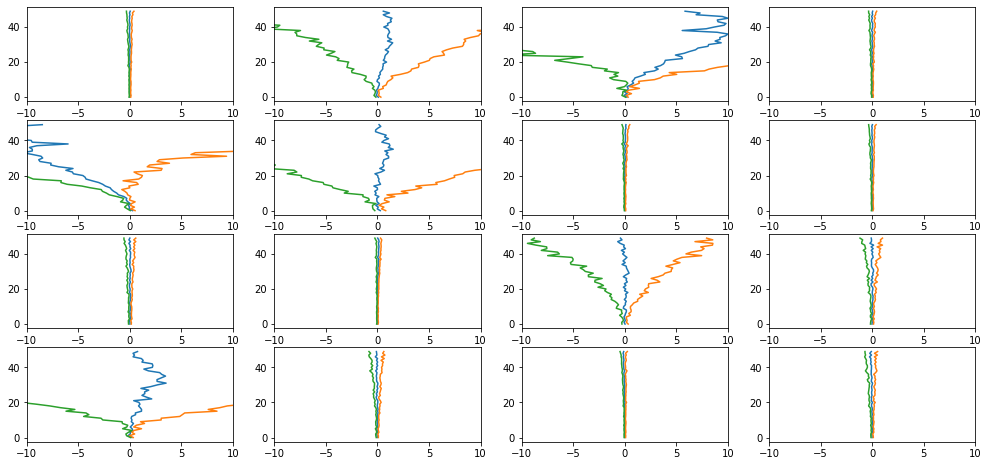

In [121]:
pred = model.predict(X)
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    traj = pred[i-1][0:50]
    std = pred[i-1][50:2*50]
    ax = fig.add_subplot(rows, columns, i)
    y = np.array(range(0, 50))
    plt.plot(traj, y)
    plt.plot( traj + 2 * std, y)
    plt.plot( traj - 2 * std, y)
    ax.set_xlim([-10, 10])
plt.show()

In [3]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


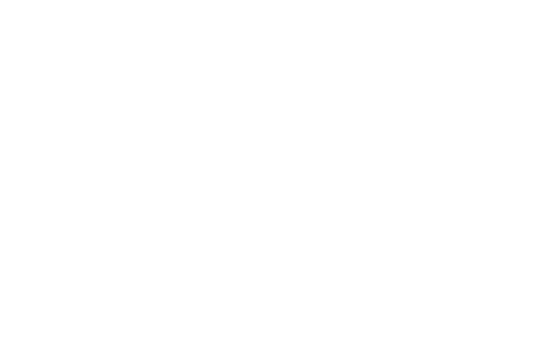

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


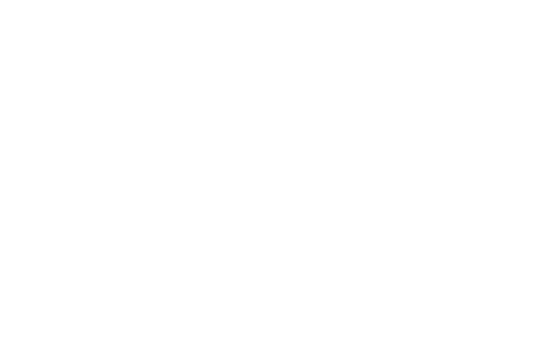

In [8]:
heads = 0
tails = 0

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

arr = []

for i in range(10):
    arr = []
    heads = 0
    tails = 0
    for j in range(100):
        if np.random.random() < 0.5:
            heads += 1
        else:
            tails += 1
            
        prob_heads = heads / (heads + tails)
        arr.append(prob_heads)
        ax.plot(arr)
        fig.canvas.draw()
        